In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import analysis
import processing
import runner
import matplotlib.pyplot as plt
import scipy

from scipy.signal import hilbert

/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out


# Synchronization

In [2]:
# TODO: load persisted model to skip training time
model = runner.run(modified_params={
    "N_pop": 2
}, file_name="coupled_synch")

initializing net ...
initialization time: 0.5403189659118652s
------------------ running network!
runtime: 21.1


INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


In [3]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("coupled_synch")

In [3]:
lfp1, lfp2 = processing.lfp_nets(model)

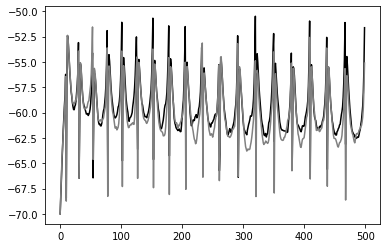

In [4]:
plt.plot(lfp1, c="black")
plt.plot(lfp2, c="grey")
plt.show()

## Phase Synchronization

* http://www.scholarpedia.org/article/Synchronization_measures#Phase_synchronization
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

Phase Difference plot shows promising results. However, there are still some extreme values that we should filter out.
Maybe limit to certain frequency spectrum?

In [ ]:
analytic_signal = hilbert(lfp1)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(analytic_signal, c='black')
axs[0].set_title("Analytic Signal")

axs[1].plot(amplitude_envelope, c='orange')
axs[1].set_title("Amplitude Envelope")

axs[2].plot(instantaneous_phase, c='green')
axs[2].set_title("Instantaneous Phase")

## Cross Correlate

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

In [ ]:
correlate = scipy.signal.correlate(lfp1, lfp2, mode='same') / lfp1.shape[0]
plt.plot(correlate, c="black")

## Coherence

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html

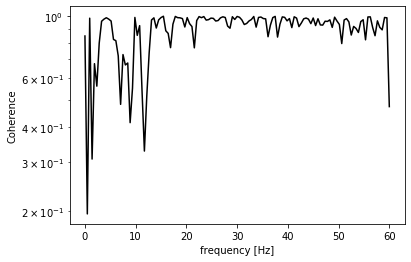

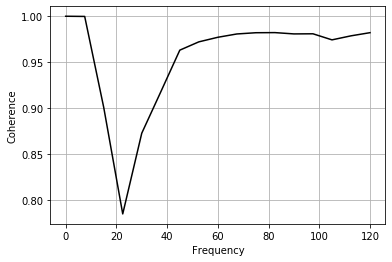

In [8]:
f, Cxy = scipy.signal.coherence(lfp1, lfp2, fs=120)
plt.semilogy(f, Cxy, c="black")
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

# NFFT: block size for FFT,  32ms blocks
Cxy, freqs = plt.cohere(lfp1, lfp2, NFFT=32, Fs=240, c="black")
plt.show()